# Import Functions

In [ ]:
import pandas as pd
from tqdm import tqdm
import random as rd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# Initiate lists of data to load into training

## Product Types list and query funciton

In [ ]:
def product_list_creation(file_name: str) -> list:
    products_df = pd.read_excel(file_name, sheet_name='product_type')

    unique_family = products_df['Family'].dropna().unique().tolist()
    product_types = products_df['ProductType'].dropna().tolist()
    keywords = [i.split(', ') for i in products_df['Keywords'].dropna().tolist()]
    keyword_list = list(set([w for word in keywords for w in word]))

    product_types.extend(keyword_list)
    product_types.extend(unique_family)
    product_types = list(set(product_types))
    return product_types

In [ ]:
def product_query(product_types):
    queries = []
    labels = []
    for word in product_types:
        labels_product = ['B-Product'] + ['I-Product'] * (len(word.split(' ')) - 1)
        queries.append(word.split(' '))
        labels.append(labels_product)
    return queries, labels

## Material Types list and query function

In [ ]:
def material_list_creation(file_name: str) -> list:
    materials_df = pd.read_excel(file_name, sheet_name='material_type')

    material_types = materials_df['material_type'].dropna().tolist()
    mat_fam = materials_df['family'].dropna().tolist()
    mat_k_word = list(set([w for words in [i.split(', ') for i in materials_df['keywords'].dropna().tolist()] for w in words]))

    material_types.extend(mat_fam)
    material_types.extend(mat_k_word)
    material_types = list(set(material_types))
    return material_types

In [ ]:
def material_query(material_types):
    queries = []
    labels = []
    for word in material_types:
        labels_material = ['B-Material'] + ['I-Material'] * (len(word.split(' ')) - 1)
        queries.append(word.split(' '))
        labels.append(labels_material)
    return queries, labels

## Building Applications list and query function

In [ ]:
def building_app_list_creation(file_name: str) -> list:
    building_app_df = pd.read_excel(file_name, sheet_name='building_applications')

    building_app_list = building_app_df['building_applications'].dropna().tolist()
    keywords = list(set([w for words in [i.split(', ') for i in building_app_df['keywords'].dropna().tolist()] for w in words]))
    building_app_list.extend(keywords)
    return building_app_list

In [ ]:
def building_app_query(building_app_list):
    queries = []
    labels = []
    for word in building_app_list:
        labels_building_application = ['B-Application'] + ['I-Application'] * (len(word.split(' ')) - 1)
        queries.append(word.split(' '))
        labels.append(labels_building_application)
    return queries, labels

## Country list and query function

In [ ]:
def country_list_creation(file_name: str) -> list:
    country_df = pd.read_excel(file_name, sheet_name='countries')
    country_list = country_df['country'].dropna().tolist()
    return country_list

In [ ]:
def country_query(country_list):
    queries = []
    labels = []
    for word in country_list:
        labels_country = ['B-Country'] + ['I-Country'] * (len(word.split(' ')) - 1)
        queries.append(word.split(' '))
        labels.append(labels_country)
    return queries, labels

## Recycled Content list and query

In [ ]:
def recycled_list_creation(file_name: str) -> list:
    recycled_content_df = pd.read_excel(file_name, sheet_name='recycled_content')
    recycled_list = recycled_content_df['recycled_content'].dropna().str.lower().tolist()
    recycle_keywords = list(set([w for words in [i.split(', ') for i in recycled_content_df['keywords'].dropna().tolist()] for w in words]))
    recycled_list.extend(recycle_keywords)

    final_list = []
    for item in recycled_list:
        if 'x%' in item:
            for _ in range(21):
                final_list.append(item.replace('x%', str(rd.randint(0, 100)) + '%'))
        elif '.x' in item:
            for _ in range(21):
                final_list.append(item.replace('.x', '.' + str(rd.randint(0, 100))))
        else:
            final_list.append(item)
    return final_list

In [ ]:
def recycle_query(recycled_list):
    queries = []
    labels = []
    for word in recycled_list:
        labels_country = ['B-Recycle'] + ['I-Recycle'] * (len(word.split(' ')) - 1)
        queries.append(word.split(' '))
        labels.append(labels_country)
    return queries, labels

## Initiation of all lists

In [ ]:
def list_initialization(file_name: str ='categories_w_keywords.xlsx'):
    product_types = product_list_creation(file_name)
    material_types = material_list_creation(file_name)
    building_app_list = building_app_list_creation(file_name)
    country_list = country_list_creation(file_name)
    recycled_list = recycled_list_creation(file_name)

    return product_types, material_types, building_app_list, country_list, recycled_list

## Creates query with proper label for every word in product types, material types, building applications, countries, and recycled content

In [ ]:
def all_queries(product_types, material_types, building_app_list, country_list, recycled_list):
    queries = []
    labels = []

    p_queries, p_labels = product_query(product_types)
    queries.extend(p_queries)
    labels.extend(p_labels)

    m_queries, m_labels = material_query(material_types)
    queries.extend(m_queries)
    labels.extend(m_labels)

    b_queries, b_labels = building_app_query(building_app_list)
    queries.extend(b_queries)
    labels.extend(b_labels)

    c_queries, c_labels = country_query(country_list)
    queries.extend(c_queries)
    labels.extend(c_labels)

    r_queries, r_labels = recycle_query(recycled_list)
    queries.extend(r_queries)
    labels.extend(r_labels)

    return queries, labels

## Creation of template sentences, all words in database added with "all_words='y'"

In [ ]:
def new_sentences(num, product_types, material_types, building_app_list, country_list, recycled_list, all_words='n'):
    templates = [
                 "{product_type} products manufactured {country} for {building_application}",
                 "{material_type} manufactured in {country} for {building_application} with {recycled_content} recycled content",
                 "{product_type} manufactured {country} with {recycled_content} recycled content",
                 "{product_type} made in {country} for {building_application} with {recycled_content} recycle content",
                 "Find {product_type} from {country} used in {building_application}",
                 "Do you have any {product_type} used in {building_application}?",
                 "I'm looking for {material_type} products from {country} for {building_application}.",
                 "{product_type} from {country} suitable for {building_application}?",
                 "Search for {material_type} materials from {country} used in {building_application} applications",
                 "Can I find {product_type} suitable for {building_application} applications?",
                 "What types of {material_type} from {country} are used in {building_application}?",
                 "Show me {product_type} suitable for {building_application}",
                 "List all {material_type} from {country} used in {building_application}.",
                 "Are there any {product_type} from {country} for {building_application}?",
                 "Find {product_type} with {recycled_content} recycled content.",
                 "Find {material_type} with {recycled_content} recycled content.",
                 "List all {material_type} from {country} with recycled content {recycled_content} "
                 ]

    queries = []
    labels = []

    for null in range(num):
        temp = rd.choice(templates)
        material_type = rd.choice(material_types)
        product_type = rd.choice(product_types)
        building_application = rd.choice(building_app_list)
        country = rd.choice(country_list)
        recycled_content = rd.choice(recycled_list)
        sentence = temp.format(
                                material_type=material_type,
                                product_type=product_type,
                                building_application=building_application,
                                country=country,
                                recycled_content=recycled_content
                                )

        queries.append(sentence.lower())
        # Generate labels
        labels_product = ['B-Product'] + ['I-Product'] * (len(product_type.split(' ')) - 1)
        labels_material = ['B-Material'] + ['I-Material'] * (len(material_type.split(' ')) - 1)
        labels_country = ['B-Country'] + ['I-Country'] * (len(country.split(' ')) - 1)
        labels_building_application = ['B-Application'] + ['I-Application'] * (len(building_application.split(' ')) - 1)
        labels_recycled_content = ['B-Recycle'] + ['I-Recycle'] * (len(str(recycled_content).split(' ')) - 1)

        # Identify the placeholders in the template and replace them with the corresponding labels
        template_labels = temp.split()
        new_template_labels = []
        for word in template_labels:
            if 'product_type' in word:
                new_template_labels.extend(labels_product)
            elif 'material_type' in word:
                new_template_labels.extend(labels_material)
            elif 'country' in word:
                new_template_labels.extend(labels_country)
            elif 'building_application' in word:
                new_template_labels.extend(labels_building_application)
            elif 'recycled_content' in word:
                new_template_labels.extend(labels_recycled_content)
            else:
                new_template_labels.append('O')

        template_labels = new_template_labels
        labels.append(template_labels)

    if all_words == 'y':
        solo_queries, solo_labels = all_queries(product_types, material_types, building_app_list, country_list, recycled_list)
        queries.extend(solo_queries)
        labels.extend(solo_labels)
        print(f'{len(solo_queries)} words from database and {num} random sentences added to queries and labels data.')
    else:
        print(f'{num} random sentences added to queries and labels data.')
    return queries, labels

## CustomDataset class to process words for tokeninzer

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, max_len, pad_token_label_id):
        self.len = len(sentences)
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_token_label_id = pad_token_label_id

    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        label = ['O'] + self.labels[index] + ['O']
        label = [Token_Classification_Labels.get(l) for l in label]
        padding_length = self.max_len - len(label)
        label.extend([self.pad_token_label_id]*padding_length)
        label = label[:self.max_len]
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return self.len

## Loads queries and labels into train dataset to prepare for training

In [ ]:
def train_data_info(queries, labels, tokenizer):
    # First, split into train+val and test sets
    sentences_temp, sentences_test, labels_temp, labels_test = train_test_split(queries, labels, test_size=0.1, random_state=42)

    # Then split train+val into separate train and val sets
    sentences_train, sentences_val, labels_train, labels_val = train_test_split(sentences_temp, labels_temp, test_size=0.1, random_state=42)

    # Padding label
    PAD_TOKEN_LABEL_ID = -100

    # Now, prepare the training, validation, and test data
    train_data = CustomDataset(tokenizer, sentences_train, labels_train, max_len=50, pad_token_label_id=PAD_TOKEN_LABEL_ID)
    valid_data = CustomDataset(tokenizer, sentences_val, labels_val, max_len=50, pad_token_label_id=PAD_TOKEN_LABEL_ID)
    test_data = CustomDataset(tokenizer, sentences_test, labels_test, max_len=50, pad_token_label_id=PAD_TOKEN_LABEL_ID)

    # Initialize the data loaders
    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)  # we don't need to shuffle the test set
    return train_dataloader, valid_dataloader, test_dataloader

### Initialize Tokenizer

In [ ]:
def Initialize_tokenizer():
    from transformers import DistilBertTokenizerFast
    # Initialize the tokenizer
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    return tokenizer

### Token Classification Labels and Model Initialization

In [ ]:
def Token_Classification_Initialization():
    from transformers import DistilBertForTokenClassification
    Token_Classification_Labels = {
                                  'O': 0,
                                  'B-Product': 1,
                                  'I-Product': 2,
                                  'B-Material': 3,
                                  'I-Material': 4,
                                  'B-Country': 5,
                                  'I-Country': 6,
                                  'B-Application': 7,
                                  'I-Application': 8,
                                  'B-Recycle': 9,
                                  'I-Recycle': 10
                                  }
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    Token_Classification_model = DistilBertForTokenClassification.from_pretrained(
                                    "distilbert-base-uncased",
                                    num_labels=len(Token_Classification_Labels)).to(device)
    return Token_Classification_Labels, Token_Classification_model

### Token Classification Model Training

In [ ]:
def Token_Classification_Model_Training(
                                        Token_Classification_Labels: dict,
                                        Token_Classification_model,
                                        train_dataloader,
                                        test_dataloader,
                                        Model_load_file: None|str = None,
                                        learning_rate: float = 1e-5,
                                        epoch_loop : int = 5
                                        ) -> list:
    optimizer = torch.optim.AdamW(params=Token_Classification_model.parameters(), lr=learning_rate)
    # Loads model if there is provided file name
    if Model_load_file:
        Token_Classification_model.load_state_dict(torch.load(Model_load_file))
        print(f'{Model_load_file} successfully loaded.')
    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Token_Classification_model.to(device)

    Token_Classification_model.train()

    # Training loop
    training_loss = []
    raw_results = []
    print('Training starting.')
    for null in tqdm(range(epoch_loop)):  # loop over the dataset multiple time
        total_loss = 0
        for i, batch in enumerate(train_dataloader, 0):
            # zero the parameter gradients
            optimizer.zero_grad()

            # get the inputs
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            masks = batch['attention_mask'].to(device)

            # forward + backward + optimize
            outputs = Token_Classification_model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            # add the loss to the list
            total_loss += loss.item()

        Token_Classification_model.eval()

        predictions = []
        true_labels = []

        for i, batch in enumerate(test_dataloader):
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            with torch.no_grad():
                outputs = Token_Classification_model(b_input_ids, attention_mask=b_input_mask)

            logits = outputs[0].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the predictions
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.extend(label_ids)

        # Define mapping from index to labels
        idx2label = {v: k for k, v in Token_Classification_Labels.items()}
        idx2label[-100] = 'PAD'

        # Flatten the output tensors
        predictions_flat = [item for sublist in predictions for item in sublist]
        true_labels_flat = [item for sublist in true_labels for item in sublist]

        # Map indices back to labels
        pred_tags_flat = [idx2label[p] for p in predictions_flat]
        true_tags_flat = [idx2label[t] for t in true_labels_flat]

        # Filter out 'PAD' labels
        pred_tags = [pred for pred, true in zip(pred_tags_flat, true_tags_flat) if true != 'PAD']
        true_tags = [true for true in true_tags_flat if true != 'PAD']

        # Binarize the labels
        lb = LabelBinarizer()
        y_true_combined = lb.fit_transform(true_tags)
        y_pred_combined = lb.transform(pred_tags)

        # appends classification report into list for each epoch
        class_report = classification_report(y_true_combined, y_pred_combined, target_names=lb.classes_, digits=4, zero_division=1, output_dict=True)
        raw_results.append(class_report)
        Token_Classification_model.train()

        # Save training loss
        training_loss.append(total_loss/len(train_dataloader))

    raw_results.append(training_loss)
    print('Training Complete.')
    if Model_load_file:
        torch.save(Token_Classification_model.state_dict(), Model_load_file)
        print(f'{Model_load_file} successfully saved.')
    else:
        Model_load_file = 'Token_Class_Model.pth'
        torch.save(Token_Classification_model.state_dict(), Model_load_file)
        print(f'{Model_load_file} successfully saved.')
    return raw_results

## Organizes results from training into dictionary

In [ ]:
def results_dict_creation(raw_results: list) -> dict:
    training_loss = raw_results.pop()
    results_dict = {
                'epoch': [],
                'precision': [],
                'recall': [],
                'f1_score': [],
                'training loss': []
                }
    for index, item in enumerate(raw_results):
        results_dict['epoch'].append(index+1)
        results_dict['precision'].append(item['weighted avg']['precision'])
        results_dict['recall'].append(item['weighted avg']['recall'])
        results_dict['f1_score'].append(item['weighted avg']['f1-score'])
        results_dict['training loss'].append(training_loss[index])
    return results_dict

## Takes Epoch df column and column to compare to output graph of progression over each epoch

In [ ]:
def plot_creation(epochs, y_value):
    import matplotlib.pyplot as plt

    epoch_nums = epochs.tolist()
    y_val_list = y_value.tolist()

    x = epochs.values.reshape(-1,1)
    y = y_value.values.reshape(-1,1)

    linear_r = LinearRegression()
    linear_r.fit(x, y)
    y_pred = linear_r.predict(x)
    plt.plot(epoch_nums, y_pred, color='red', linestyle='dashdot')

    plt.plot(epoch_nums, y_val_list, color='blue')
    plt.title(y_value.name)
    plt.xlabel('epoch')
    plt.legend(['linear regression',y_value.name])

    plt.tight_layout()
    plt.show()

## Saves results of training into .csv file

In [ ]:
def save_results(df):
    import datetime
    import pytz
    current_time = datetime.datetime.now(pytz.timezone('Etc/GMT-2'))
    save_location = '../datasets_and_models///token_class_training_results/' + current_time.strftime('%Y-%m-%d_%H-%M-%S') + '.csv'
    df.to_csv(save_location, sep=',', index=False)
    print(f'File {save_location} saved.')

## Function to take sentance/query from user and process result, output in dictionary {str:list}

In [ ]:
def Token_Classification_Results(List_of_Sentences: list,
                                 Token_Classification_Labels: dict,
                                 Token_Classification_model,
                                 tokenizer,
                                 Token_Class_File: str
                                 ) -> dict:
    # Puts model into eval mode
    Token_Classification_model.eval()

    # Loads the saved file of Pre-trained model
    Token_Classification_model.load_state_dict(torch.load(Token_Class_File))
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Inverse mapping from label indices to labels
    inv_label_map = {v: k for k, v in Token_Classification_Labels.items()}

    # Creating Final Dictionary for results
    final_dict = {
                  'Product Type': [],
                  'Material Type': [],
                  'Building applications': [],
                  'Countries': [],
                  'Recycled Content': []
                  }

    # Cycling through query
    for sentence in List_of_Sentences:
        sentence = sentence.lower()
        # Encode the sentence
        inputs = tokenizer.encode_plus(
                                        sentence,
                                        None,
                                        add_special_tokens=True,
                                        padding='longest',
                                        return_token_type_ids=True
                                        )

        # Create torch tensors and move them to the device
        input_ids = torch.tensor([inputs['input_ids']], dtype=torch.long).to(device)
        attention_mask = torch.tensor([inputs['attention_mask']], dtype=torch.long).to(device)

        # Run the sentence through the model
        with torch.no_grad():
            outputs = Token_Classification_model(input_ids, attention_mask=attention_mask)

        # Get the token-level class probabilities
        logits = outputs[0]

        # Compute the predicted labels
        predictions = torch.argmax(logits, dim=-1)

        # Remove padding and special tokens
        input_ids = input_ids[0].tolist()
        predictions = predictions[0].tolist()

        real_input_ids = [id for id, pred in zip(input_ids, predictions) if id != 0 and id != 101 and id != 102]
        real_predictions = [pred for id, pred in zip(input_ids, predictions) if id != 0 and id != 101 and id != 102]

        # real_input_ids = []
        # real_predictions = []
        #
        # for id, pred in zip(input_ids, predictions):
        #     if id != 0 and id != 101 and id != 102: # Ignore [PAD], [CLS] and [SEP] tokens
        #         real_input_ids.append(id)
        #         real_predictions.append(pred)

        # Map predicted label indices back to label strings
        predicted_labels = [inv_label_map[label] for label in real_predictions]

        # Combine tokens and their predicted labels into dict
        results = dict(zip(sentence.split(' '), predicted_labels))

        # Put results into final_dict, key is word and value is what it is labeled as
        for word, label in results.items():
            print(word, label)
            if word in ['for', 'and', 'from']:
                continue
            if label != 'O':
                # Adds word to proper dictionary if belongs to that type

                # Checks if there is a B-word before the I-word so it will add to it

                # It will make a new word if there is no B-word

                if label == 'B-Product':
                    final_dict['Product Type'].append(word)

                elif label == 'I-Product':

                  if final_dict['Product Type']:
                    final_dict['Product Type'][-1] += ' ' + word
                  else:
                    final_dict['Product Type'].append(word)

                elif label == 'B-Material':
                    final_dict['Material Type'].append(word)

                elif label == 'I-Material':

                  if final_dict['Material Type']:
                    final_dict['Material Type'][-1] += ' ' + word
                  else:
                     final_dict['Material Type'].append(word)

                elif label == 'B-Country':
                    final_dict['Countries'].append(word)

                elif label == 'I-Country':

                  if final_dict['Countries']:
                    final_dict['Countries'][-1] += ' ' + word
                  else:
                    final_dict['Countries'].append(word)

                elif label == 'B-Application':
                    final_dict['Building applications'].append(word)

                elif label == 'I-Application':

                  if final_dict['Building applications']:
                    final_dict['Building applications'][-1] += ' ' + word
                  else:
                    final_dict['Building applications'].append(word)

                elif label == 'B-Recycle':
                    final_dict['Recycled Content'].append(word)

                elif label == 'I-Recycle':

                    if final_dict['Recycled Content']:
                        final_dict['Recycled Content'][-1] += ' ' + word
                    else:
                        final_dict['Recycled Content'].append(word)
        print('\n')


    return final_dict

# Testing

## Model Initialization

In [ ]:
Token_Classification_Labels, Token_Classification_model = Token_Classification_Initialization()

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Reads excel file with all information

In [ ]:
excel_file = '../datasets_and_models/categories_w_keywords.xlsx'

product_types, material_types, building_app_list, country_list, recycled_list  = list_initialization(excel_file)

### Creates new sentences and labels to train model on

In [ ]:
queries, labels = new_sentences(3000, product_types, material_types, building_app_list, country_list, recycled_list, all_words='n')

3000 random sentences added to queries and labels data.


In [ ]:
tokenizer = Initialize_tokenizer()

### Sets up training, valid, and test data for model training

In [ ]:
train_dataloader, valid_dataloader, test_dataloader = train_data_info(queries=queries, labels=labels, tokenizer=tokenizer)
model_file = '../datasets_and_models/Token_Class_Model.pth'

### Trains model, intakes labels, model, train data, test data, model file location, learning rate, and epoch loop (times trained)

In [ ]:
raw_results = Token_Classification_Model_Training(Token_Classification_Labels=Token_Classification_Labels,
                                                  Token_Classification_model=Token_Classification_model,
                                                  train_dataloader=train_dataloader,
                                                  test_dataloader=test_dataloader,
                                                  Model_load_file=model_file,
                                                  learning_rate=1e-5,
                                                  epoch_loop=5)

../datasets_and_models/Token_Class_Model.pth successfully loaded.
Training starting.


100%|██████████| 5/5 [28:44<00:00, 344.91s/it]


Training Complete.
../datasets_and_models/Token_Class_Model.pth successfully saved.


In [ ]:
results_dict = results_dict_creation(raw_results)

In [ ]:
df = pd.DataFrame.from_dict(results_dict)
save_results(df)

File ../datasets_and_models///token_class_training_results/2023-08-08_21-31-44.csv saved.


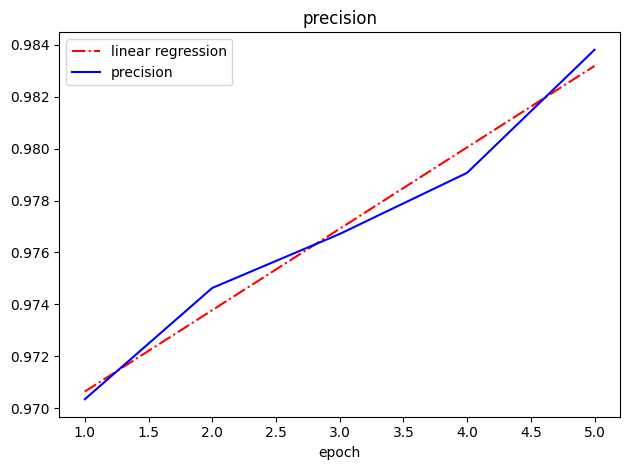

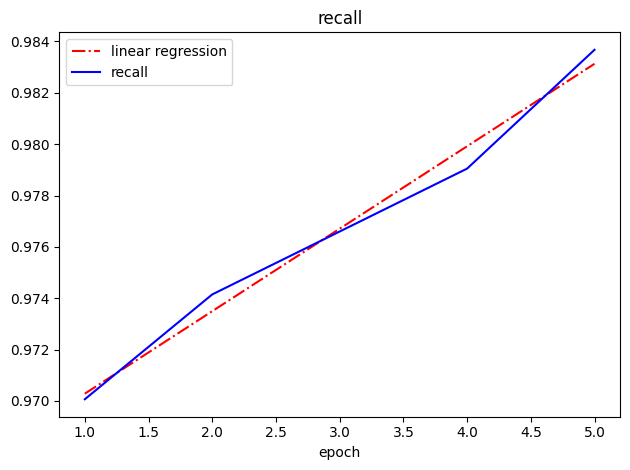

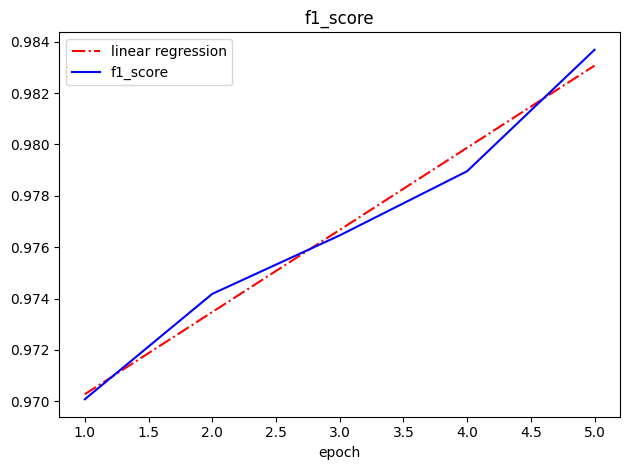

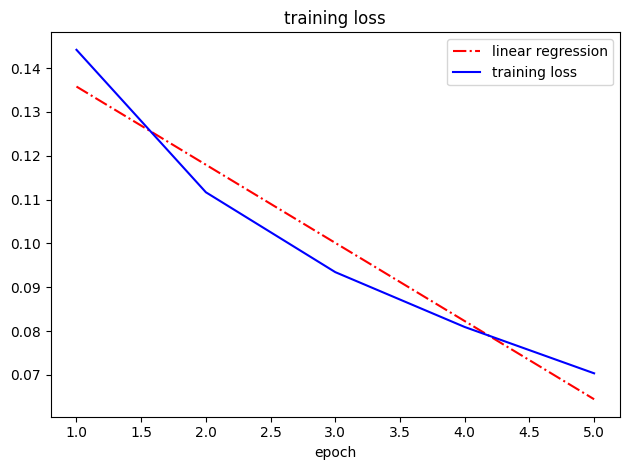

In [ ]:
for index in range(1, 5):
    plot_creation(df.iloc[:, 0], df.iloc[:, index])

In [ ]:
list_of_sentences = new_sentences(2,
                                  product_types=product_types,
                                  material_types=material_types,
                                  building_app_list=building_app_list,
                                  country_list=country_list,
                                  recycled_list=recycled_list,
                                  all_words='n')
list_of_sentences = [['metal material with 70% recycle content']]
final_output = Token_Classification_Results(List_of_Sentences=list_of_sentences[0],
                                            Token_Classification_Labels=Token_Classification_Labels,
                                            Token_Classification_model=Token_Classification_model,
                                            tokenizer=tokenizer,
                                            Token_Class_File=model_file
                                            )

2 random sentences added to queries and labels data.
metal B-Product
material I-Product
with O
70% B-Recycle
recycle O
content O


In [ ]:
final_output

{'Product Type': ['metal material'],
 'Material Type': [],
 'Building applications': [],
 'Countries': [],
 'Recycled Content': ['70%']}